In [103]:
import os,glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [104]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [105]:
file_path = 'traindata'

In [106]:
name_class = os.listdir(file_path)
name_class

['benign', 'malignant']

In [107]:
file_paths = list(glob.glob(file_path + '/**/*.*', recursive=True))
print(file_paths)

['traindata\\benign\\melanoma_0.jpg', 'traindata\\benign\\melanoma_1.jpg', 'traindata\\benign\\melanoma_10.jpg', 'traindata\\benign\\melanoma_100.jpg', 'traindata\\benign\\melanoma_1000.jpg', 'traindata\\benign\\melanoma_1001.jpg', 'traindata\\benign\\melanoma_1002.jpg', 'traindata\\benign\\melanoma_1003.jpg', 'traindata\\benign\\melanoma_1004.jpg', 'traindata\\benign\\melanoma_1005.jpg', 'traindata\\benign\\melanoma_1006.jpg', 'traindata\\benign\\melanoma_1007.jpg', 'traindata\\benign\\melanoma_1008.jpg', 'traindata\\benign\\melanoma_1009.jpg', 'traindata\\benign\\melanoma_101.jpg', 'traindata\\benign\\melanoma_1010.jpg', 'traindata\\benign\\melanoma_1011.jpg', 'traindata\\benign\\melanoma_1012.jpg', 'traindata\\benign\\melanoma_1013.jpg', 'traindata\\benign\\melanoma_1014.jpg', 'traindata\\benign\\melanoma_1015.jpg', 'traindata\\benign\\melanoma_1016.jpg', 'traindata\\benign\\melanoma_1017.jpg', 'traindata\\benign\\melanoma_1018.jpg', 'traindata\\benign\\melanoma_1019.jpg', 'traindat

In [108]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))
print(labels)

['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign',

In [109]:
filepath = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,label
0,traindata\benign\melanoma_2490.jpg,benign
1,traindata\benign\melanoma_261.jpg,benign
2,traindata\benign\melanoma_3093.jpg,benign
3,traindata\malignant\melanoma_5621.jpg,malignant
4,traindata\benign\melanoma_2216.jpg,benign


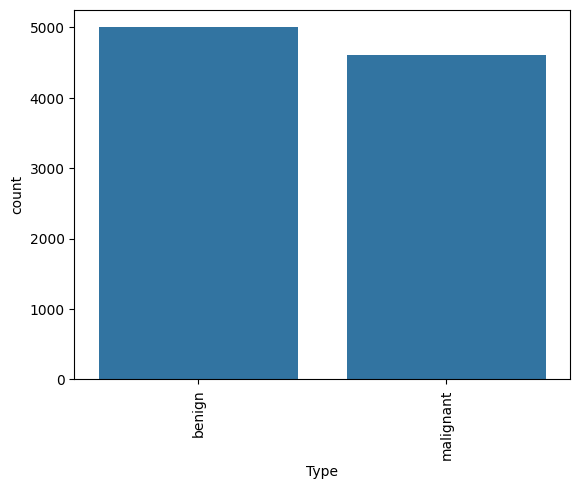

In [110]:
counts = data['label'].value_counts()
# Plotting the bar plot using Seaborn
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

In [111]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

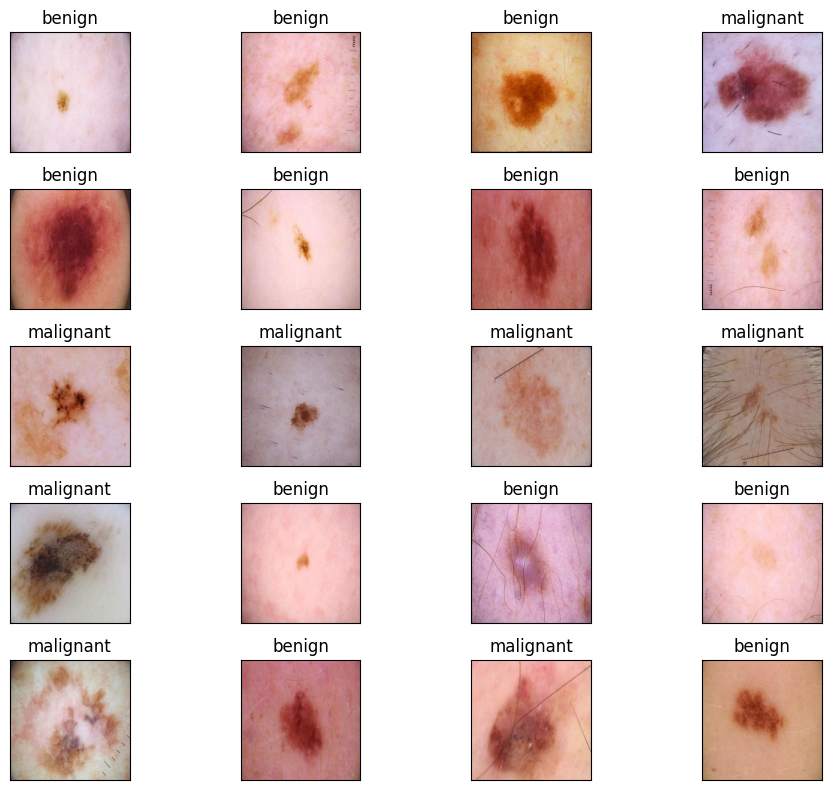

In [112]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.label[i])
plt.tight_layout()
plt.show()

In [113]:
#Initialize the ImageData Generator for the data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [114]:
#Creating data generators for training and validation
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
#creating data generator for the test data
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
#creating data generator for the test data without shuffling
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Found 7203 validated image filenames belonging to 2 classes.
Found 2402 validated image filenames belonging to 2 classes.
Found 2402 validated image filenames belonging to 2 classes.


In [115]:
# Loading the pretrained ResNet50 model
pretrained_model = ResNet50(
    input_shape=(100,100,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [116]:
# Define the custom layers added to the pretrained model
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
# Define the output layer
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs = inputs, outputs = outputs)

In [117]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [118]:
my_callbacks = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=3,
                              mode='auto')]

In [119]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=my_callbacks
)

Epoch 1/100


C:\Users\NANDINI\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 211s 873ms/step - accuracy: 0.8501 - loss: 0.3476 - val_accuracy: 0.9009 - val_loss: 0.2293
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 208s 916ms/step - accuracy: 0.9213 - loss: 0.1995 - val_accuracy: 0.9163 - val_loss: 0.2030
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 182s 804ms/step - accuracy: 0.9374 - loss: 0.1644 - val_accuracy: 0.9184 - val_loss: 0.2087
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 183s 810ms/step - accuracy: 0.9391 - loss: 0.1563 - val_accuracy: 0.9213 - val_loss: 0.2054
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 179s 792ms/step - accuracy: 0.9423 - loss: 0.1341 - val_accuracy: 0.9163 - val_loss: 0.2215
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 190s 840ms/step - accuracy: 0.9551 - loss: 0.1089 - val_accuracy: 0.9180 - val_loss: 0.2215
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 177s 780ms/step - accuracy: 0.9624 - loss: 0.0971 - val_accuracy: 0.9059 - val_loss: 0.2666


In [120]:
model.save("model_resnet50.h5")

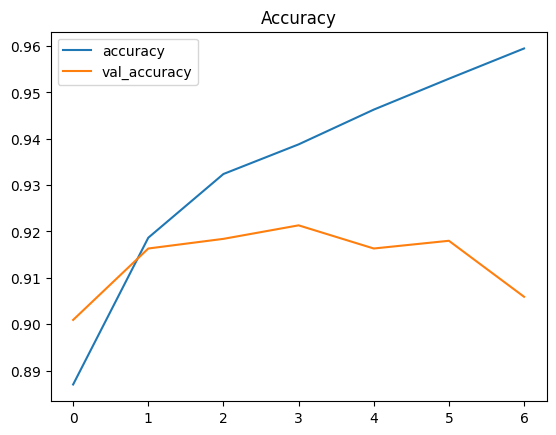

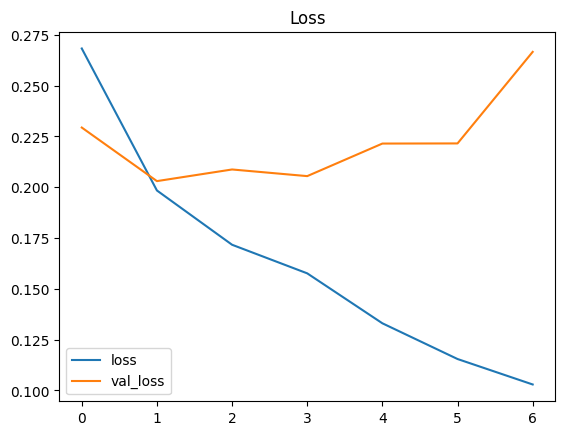

In [121]:
# Plotting the accuracy over epochs
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
# Plotting the loss over epochs
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [122]:
results = model.evaluate(test_gen, verbose=0)
# Printing the test loss and accuracy
print(" Test Los {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

C:\Users\NANDINI\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Test Los 0.26658
Test Accuracy: 90.59%


In [123]:
#Predicting the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1) # Converting predictions to label indices

#Maping the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred] 

76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 609ms/step


In [124]:
y_test = list(test['label'])  
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      benign       0.86      0.97      0.91      1234
   malignant       0.96      0.84      0.90      1168

    accuracy                           0.91      2402
   macro avg       0.91      0.90      0.91      2402
weighted avg       0.91      0.91      0.91      2402



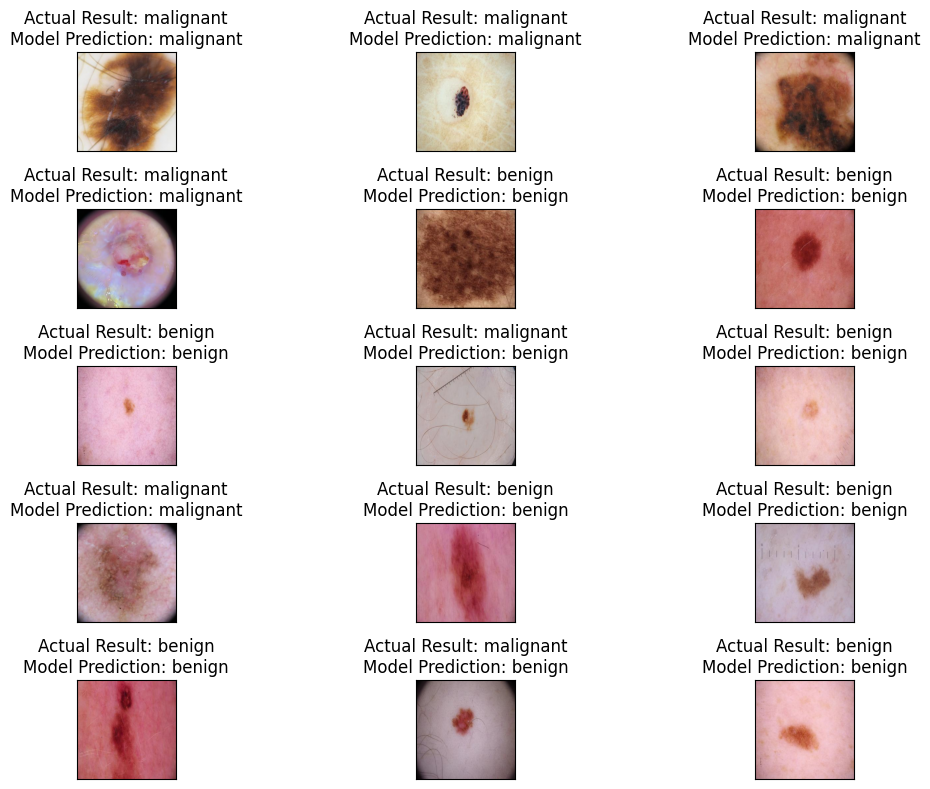

In [125]:
# Plotting sample images with actual and predicted labels
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 8),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test['Filepath'].iloc[i]))
    ax.set_title(f"Actual Result: {test['label'].iloc[i]}\nModel Prediction: {pred[i]}")
plt.tight_layout()
plt.show()

In [126]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model("model_resnet50.h5")
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [127]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[72 27]]


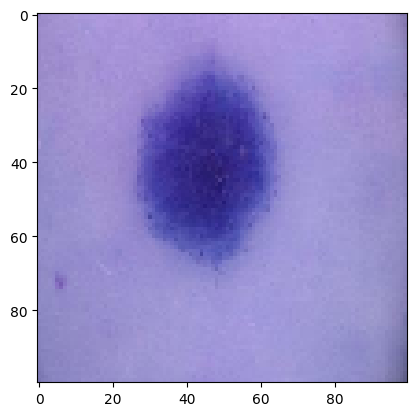

In [128]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = r'D:\Skin Cancer\testdata\benign\melanoma_9660.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (100,100))

# Preprocessing the image and make a prediction
x = np.expand_dims(img, axis=0) # Adding a batch dimension
x = preprocess_input(x)
result = loaded_model_imageNet.predict(x) 

# Print the prediction result
print((result*100).astype('int'))
plt.imshow(img)

In [129]:
p =list((result*100).astype('int'))
pp=list(p[0])
print(pp)

[72, 27]


In [130]:
print("The Largest Element is:", max(pp))

The Largest Element is: 72


In [131]:
index = pp.index(max(pp))

In [132]:
name_class=['benign','meligant']

In [133]:
name_class[index]

'benign'

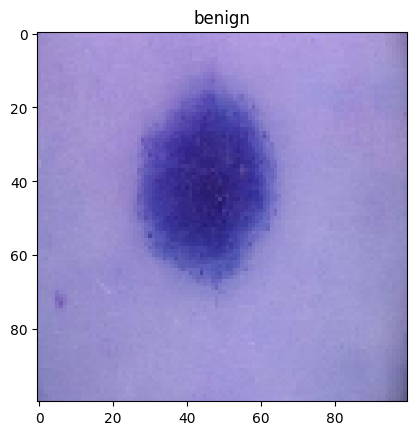

In [134]:
plt.title(name_class[index])
plt.imshow(img)